# Adversarial Attack
Adversarial Attack 이란 머신러닝 모델에 대한 적대적 예제를 인위적으로 생성하여 시스템의 성능에 악영향을 끼치게 하는 공격이다. 이미지 분류 모델을 예로 들면, 특정 이미지에 노이즈를 추가하여 육안으로는 변화가 크게 없으나 모델의 결과에는 큰 영향을 주게 하는 예제가 적대적 예제로 볼 수 있다.

## FGSM(fast gradient sign method)
FGSM 은 적대적 공격 알고리즘의 시초로써, 지나치게 선형적인 딥러닝의 특성을 이용한 알고리즘이다. 선형적인 모델의 경우, 클래스를 분류하는 기준이 되는 바운더리를 넘나드는 데이터를 만들기 용이하기 때문에 적대적 공격에 취약하다는 것이다.

FGSM 에서 적대적 예제를 만드는 과정은 다음과 같다.

$$ x = x + \delta, ||\delta||_\infty < \epsilon $$

노이즈가 클 수록 데이터에 가해지는 변형이 크기 때문에, $\delta$에 대한 유계값이 있어야 한다.

이 때 $\delta$ 의 값은 다음과 같다.  기울기 값을 이용하여 정답 레이블의 역방향으로 학습시킨다.

$$ \delta = \epsilon sign({\Delta}_x L(\theta, x, y)) $$

본문에서는 FGSM 알고리즘을 이용하여 ResNet34 모델을 공격 해본다.

In [1]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json

import matplotlib.pyplot as plt

In [2]:
resnet = models.resnet34(pretrained=True)

이미지에서 텐서로 변환하는 함수와 시각화를 위한 텐서에서 이미지로 변환하는 함수를 작성한다.

In [3]:
def toImage(img_tensor):
    img = img_tensor.squeeze(0).detach()
    img = img.transpose(0,2).transpose(0,1).numpy()
    return img

toTensor = transforms.ToTensor()

In [4]:
classes = json.load(open("data/imagenet_classes.json"))

웰시 코기 사진을 LANCZOS 필터를 이용하여 224x224 이미지로 변환한다.

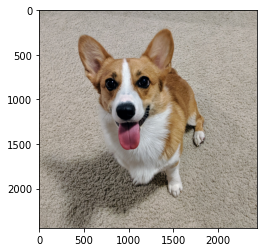

In [23]:
img = Image.open("data/corgie.jpg")
plt.imshow(img)
plt.show()

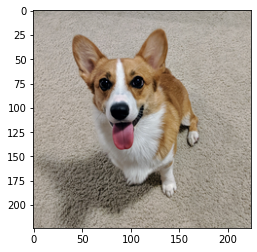

In [24]:
img = img.resize((224,224), Image.LANCZOS)
plt.imshow(img)
plt.show()

In [27]:
data = toTensor(img)
data = data.reshape(-1, 3, 224, 224)
data.size()

torch.Size([1, 3, 224, 224])

ResNet34 모델은 높은 확률로 사진이을 웰시코기로 분류했다.

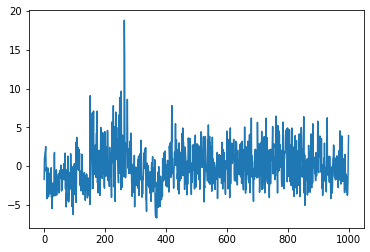

In [74]:
prob = resnet(data)
prob = prob.squeeze()
plt.plot(prob.detach().numpy())
plt.show()

In [75]:
prob.argmax()

tensor(263)

In [58]:
classes["263"]

'Pembroke, Pembroke Welsh corgi'

FGSM 알고리즘을 적용하여 적대적 예제를 만든다.

원본과 비교 했을 때 육안으로 큰 차이가 보여지지 않지만, 똑같은 모델에 적용했을 시 Ibizan hound, Ibizan Podenco 라는 다른 개 종으로 오분류한다.

In [126]:
def fgsm(model, x, y, eps):
    x_adv = x.detach().clone()
    x_adv.requires_grad = True
    model.zero_grad()
    
    loss = F.cross_entropy(model(x_adv), y)
    loss.backward()
    delta = eps * x_adv.grad.sign()
    return torch.clamp(x_adv + delta, 0, 1), delta

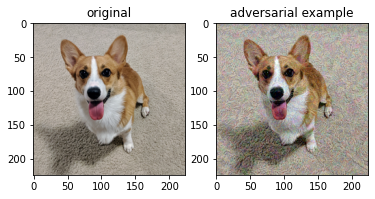

In [127]:
x_adv, d = fgsm(resnet, data, torch.tensor([263]), 0.05)

f, ax = plt.subplots(1,2) 
ax[0].imshow(toImage(data))
ax[0].set_title("original")
ax[1].imshow(toImage(x_adv))
ax[1].set_title("adversarial example")
plt.show()

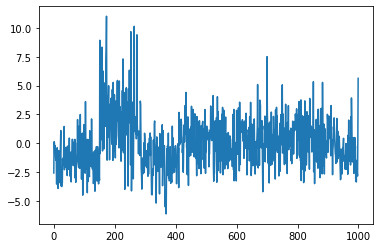

In [128]:
prob = resnet(x_adv)
prob = prob.squeeze()
plt.plot(prob.detach().numpy())
plt.show()

In [129]:
prob.argmax()

tensor(173)

In [130]:
classes["173"]

'Ibizan hound, Ibizan Podenco'

## 참고
https://yjs-program.tistory.com/171#%EC%A0%81%EB%8C%80%EC%A0%81-%EA%B3%B5%EA%B2%A9%EC%9D%98-%EC%A2%85%EB%A5%98

https://rain-bow.tistory.com/entry/%EC%A0%81%EB%8C%80%EC%A0%81-%EA%B3%B5%EA%B2%A9Adversarial-Attack-FGSMPGD